# Estimating Ocean surface circulation (from SST)


In [3]:
import glob

import numpy as np
from netCDF4 import Dataset

import torch
import torch.optim as optim

from tools import aimi_sl
from tools import NormGrad, NormDiv

import matplotlib.pyplot as plt
from middlebury import computeColor

# Loading data

The four acquisitions used to compute motion:


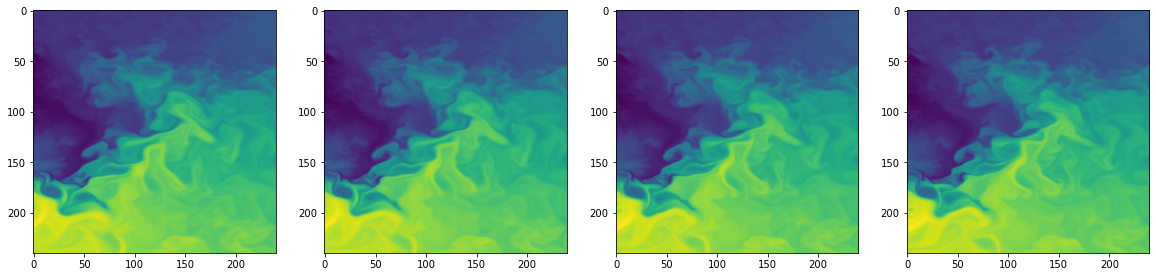

In [4]:
dir = "data/natl/"

files=sorted(glob.glob(dir+'/*.nc'))

# Region Of Interest in NATL data
rn1,rm1,rn2,rm2 = (99,269, 99+240, 269+240)

def loadsst(file):
    data = Dataset(file)
    T = data.variables['thetao'][:]
    _,_,n,m = T.shape
    T = T.reshape((n,m)).filled(T.min())
    T = np.flipud(T)
    T = T[rn1:rn2,rm1:rm2]
    return T

sstmaps = [loadsst(f) for f in files]

print( 'The four acquisitions used to compute motion:')
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(sstmaps[0])
plt.subplot(142)
plt.imshow(sstmaps[1])
plt.subplot(143)
plt.imshow(sstmaps[2])
plt.subplot(144)
plt.imshow(sstmaps[3])
plt.show()

# Motion Estimation with weak 4D-Var

In [5]:
Obs = torch.Tensor(sstmaps[:4])

# Background
Qb = Obs[0]  
Ub, Vb = torch.zeros(Qb.shape), torch.zeros(Qb.shape)
Xb = torch.stack((Ub,Vb,Qb), dim=2)

# Observation
Obs = Obs[1:]

# Model parameters
dx = dy = 10000
dt = 17280 # 4.8h = (24h/5) 
Nf = 16 # number of time steps

# Covariances Matrices
Bm1 = torch.zeros(Xb.shape)
Bm1[:,:,2] = 0.1
Rm1 = torch.ones(Obs.shape)*0.1

# Regularization parameters
alpha = 1e9
beta = 1e10
gamma = 1e9

maxiter = 300

# times for which an observation is available
tObs = [5, 10, 15]

# times for which we introduce a control on model error
tEpsM = [i-1 for i in tObs[1:]]

# initialization of semi-Lagrangrian scheme
slag_model = aimi_sl(dx, dy, dt)

# 4D-Var algorithm
Ny, Nx = Obs[0].shape
Nv = 3

EpsB = torch.zeros(Xb.shape, requires_grad=True)
EpsM = torch.zeros(len(tEpsM), Ny, Nx, Nv, requires_grad=True)
optimizer = optim.LBFGS([EpsB,EpsM], lr=1, max_iter=maxiter)

def detach(a):
    return a.detach().numpy()

JL = []
def closure():
    optimizer.zero_grad()
    X = torch.empty(Nf,Ny,Nx,Nv)

    Jobs = Jgam = Jq = 0

    # forward: time integration of X, computation of J_obs and Jgam
    X[0] = Xb + EpsB
    for t in range(1, Nf): 
        if t in tEpsM:
            # model integration when a error model is available + regul
            i = tEpsM.index(t)
            Jgam += gamma * NormGrad(EpsM[i], dx, dy).sum()            
            X[t] = slag_model.step(X[t-1], EpsM=EpsM[i])            
        else:
            X[t] = slag_model.step(X[t-1])
        if t in tObs:
            i = tObs.index(t)
            Dep = X[t,:,:,2] - Obs[i]
            Jobs += (Dep*Rm1[i]*Dep).sum()
            # optional, to improve performances see ...
            X[t,:,:,2] = Obs[tObs.index(t),:,:]

    # Background
    Dep = X[0] - Xb
    Jb = (Dep*Bm1*Dep).sum()

    # Regularization
    Jw = alpha*NormGrad(EpsB, dx, dy).sum()
    Jdiv = beta*NormDiv(EpsB, dx, dy).sum()

    J = 0.5*(Jb + Jobs + Jw + Jdiv + Jgam)
    JL.append(detach(J))

#    print('J:', detach(J))
    J.backward(retain_graph=True)
    return J

optimizer.step(closure)
print('done')

# last forward
X = torch.empty(Nf,Ny,Nx,Nv)
X[0] = Xb + EpsB
for t in range(1, Nf):
    X[t] = slag_model.step(X[t-1])


done


# Results

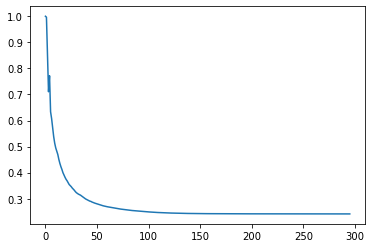

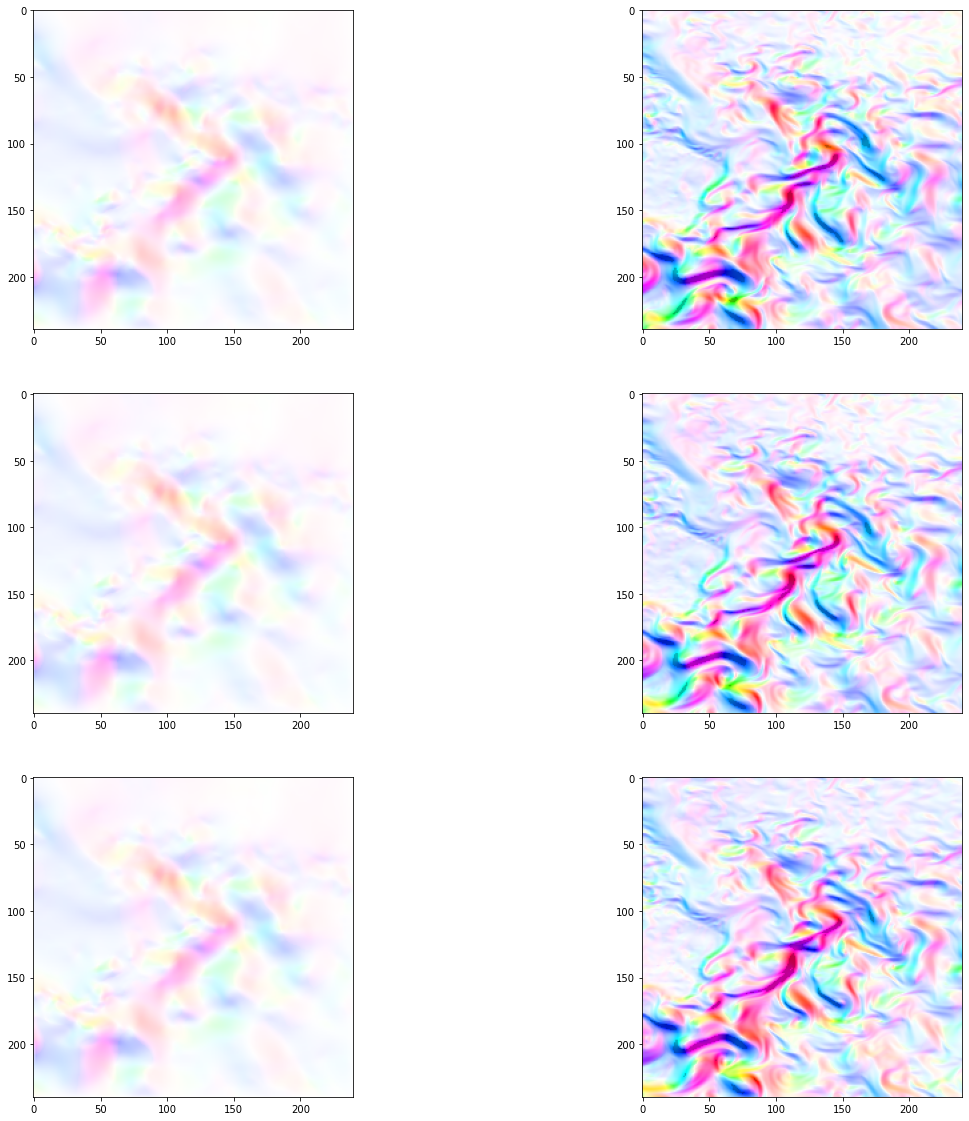

In [10]:
# optimization profile
JL = np.array(JL)/JL[0]
Jp = JL[JL<=1]
plt.plot(Jp)
plt.show()


# loading ground truth
def loaduv(file):
    """ load ground truth """
    data = Dataset(file)
    U = data.variables['uo'][:]
    _,_,n,m = U.shape
    U = U.reshape((n,m)).filled(0)
    U = np.flipud(U)
    U = U[rn1:rn2,rm1:rm2]
    
    V = data.variables['vo'][:]
    _,_,n,m = V.shape
    V = V.reshape((n,m)).filled(0)
    V = -np.flipud(V)
    V = V[rn1:rn2,rm1:rm2]
    
    return np.stack((U,V),axis=2)

# visualize velocities maps
plt.figure(figsize=(20,20))
W = X[tObs,:,:,:2]
W1 = detach(X[0])
colW1 = computeColor(W1)
GT1 = loaduv(files[1])
colGT1 = computeColor(GT1)
plt.subplot(321)
plt.imshow(colW1)
plt.subplot(322)
plt.imshow(colGT1)
W2 = detach(X[1])
colW2 = computeColor(W2)
GT2 = loaduv(files[2])
colGT2 = computeColor(GT2)
plt.subplot(323)
plt.imshow(colW2)
plt.subplot(324)
plt.imshow(colGT2)
W3 = detach(X[2])
colW3 = computeColor(W3)
GT3 = loaduv(files[3])
colGT3 = computeColor(GT3)
plt.subplot(325)
plt.imshow(colW3)
plt.subplot(326)
plt.imshow(colGT3)
plt.show()

# compute EPE

# todo

# Forecast


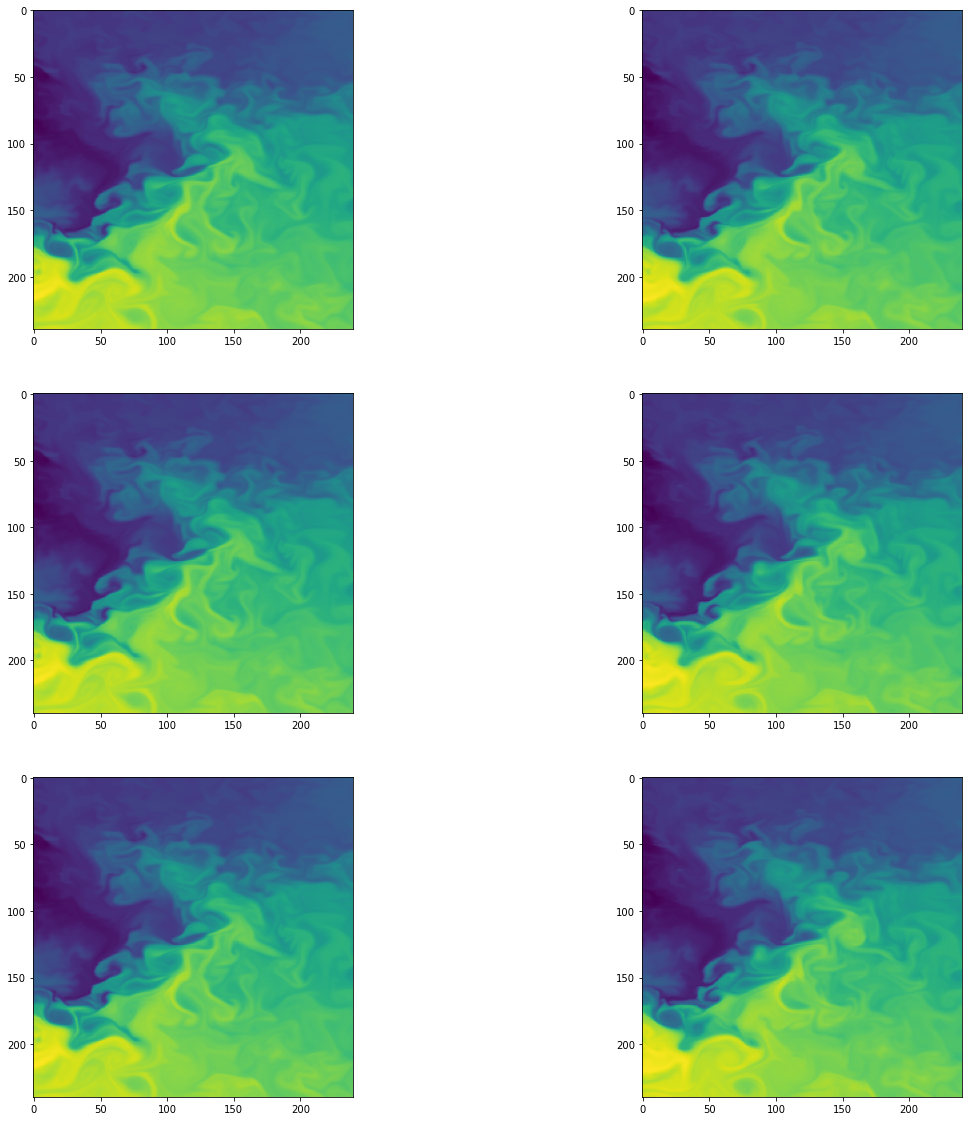

In [5]:
WRes = X[tObs[-1],:,:,:2]
LastObs = torch.Tensor(Obs[-1,:,:])

X0 = torch.stack((WRes[:,:,0],WRes[:,:,1],Obs[-1]), dim=2)
X_1 = torch.Tensor(X0)

Nf = 61
tObsForecast = [20, 40, 60]
slag_forecast = aimi_sl( dx, dy, 30, 5)

F = []
for t in range(1, Nf):
    X1 = slag_forecast.step(X0, Xm1=X_1)
    X0, X_1 = X1, X0
    if t in tObsForecast:
        F.append(detach(X1[:,:,2]))

plt.figure(figsize=(20,20))
plt.subplot(321)
plt.imshow(F[0])
plt.subplot(322)
plt.imshow(sstmaps[4])
plt.subplot(323)
plt.imshow(F[1])
plt.subplot(324)
plt.imshow(sstmaps[5])
plt.subplot(325)
plt.imshow(F[2])
plt.subplot(326)
plt.imshow(sstmaps[6])
plt.show()